In [28]:
import os
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
from tqdm import tqdm
import math

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.tensorboard import SummaryWriter
import torchvision
import torchvision.transforms as transforms
from torchvision import models


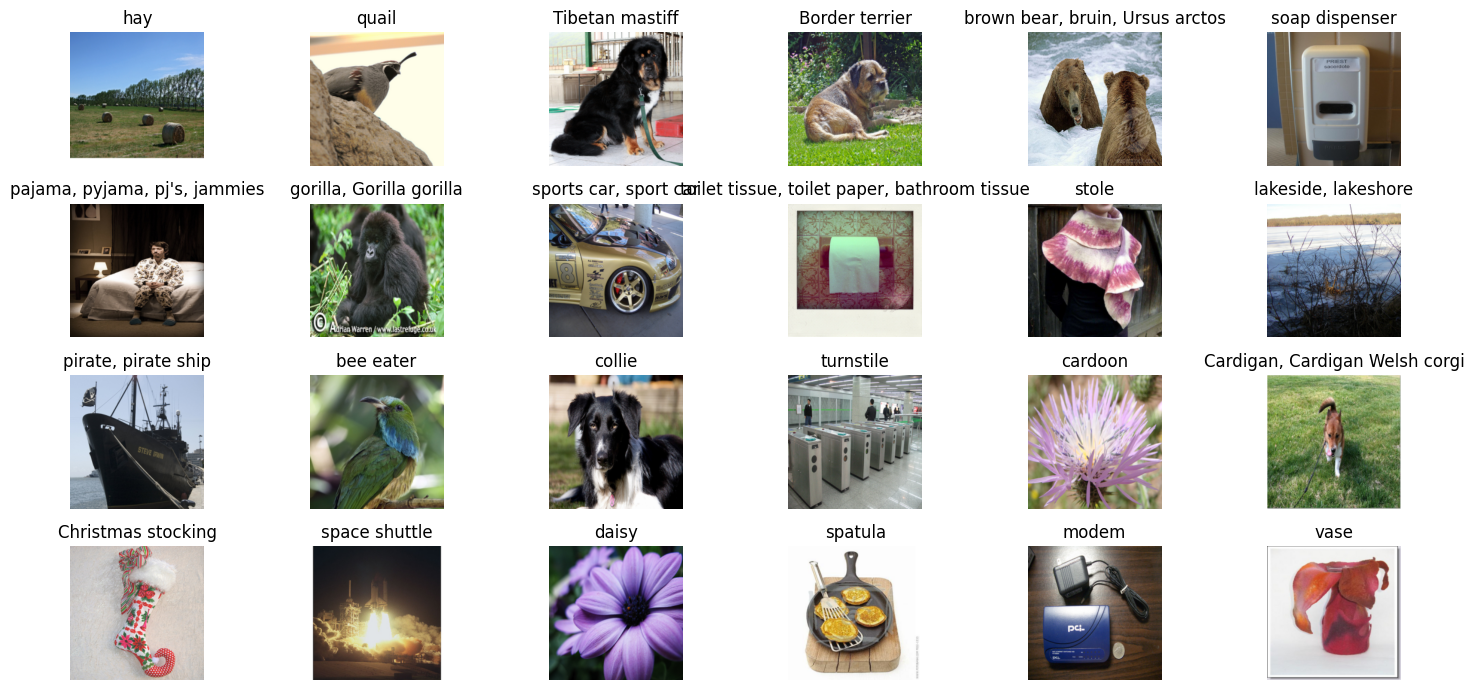

In [29]:
file_name_25_img = 'imagenet_val_25.npz'
if not os.path.exists(file_name_25_img):
    !wget https://github.com/rdfia/rdfia.github.io/raw/master/data/3-b/imagenet_val_25.npz

f = np.load("imagenet_val_25.npz", allow_pickle=True)
X, y, class_names = f["X"], f["y"], f["label_map"].item()
class_names_to_id = {name: id for id, name in class_names.items()}

plt.figure(figsize=(15, 7))
for i in range(24):
    plt.subplot(4, 6, i + 1)
    plt.imshow(X[i])
    plt.title(class_names[y[i]])
    plt.axis('off')
plt.gcf().tight_layout()


In [30]:
print(X.shape, X.dtype, type(X))

(25, 224, 224, 3) uint8 <class 'numpy.ndarray'>


In [31]:
# Load the model
model = torchvision.models.squeezenet1_1(weights=torchvision.models.SqueezeNet1_1_Weights.DEFAULT)

# Model in test mode
model.eval()

# Freeze the weights
for param in model.parameters():
    param.requires_grad = False

In [32]:
SQUEEZENET_MEAN = np.array([0.485, 0.456, 0.406], dtype=np.float32)
SQUEEZENET_STD = np.array([0.229, 0.224, 0.225], dtype=np.float32)

def preprocess_squeezenet(img, size=224):
    transform = transforms.Compose([
        transforms.Resize(size),
        transforms.ToTensor(),
        transforms.Normalize(mean=SQUEEZENET_MEAN.tolist(),
                    std=SQUEEZENET_STD.tolist()),
        transforms.Lambda(lambda x: x[None]),  # add one dimension
    ])
    return transform(img)

def deprocess_squeezenet(img, should_rescale=True):
    transform = transforms.Compose([
        transforms.Lambda(lambda x: x[0]),
        transforms.Normalize(mean=[0, 0, 0], std=(1.0 / SQUEEZENET_STD).tolist()),
        transforms.Normalize(mean=(-SQUEEZENET_MEAN).tolist(), std=[1, 1, 1]),
        transforms.Lambda(rescale) if should_rescale else transforms.Lambda(lambda x: x),
        transforms.ToPILImage(),
    ])
    return transform(img)

def rescale(x):
    low, high = x.min(), x.max()
    x_rescaled = (x - low) / (high - low)
    return x_rescaled


In [33]:
# !pip install grad-cam

In [34]:
from pytorch_grad_cam import GradCAM, GradCAMPlusPlus
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image
from torchvision.models import resnet50, ResNet50_Weights

model = resnet50(weights=ResNet50_Weights.IMAGENET1K_V1)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)    

target_layers = [model.layer4[-1]]
input_tensor = torch.cat([preprocess_squeezenet(Image.fromarray(x)) for x in X], dim=0)

# Construct the CAM object once, and then re-use it on many images:
# cam = GradCAM(model=model, target_layers=target_layers)
cam = GradCAMPlusPlus(model=model, target_layers=target_layers)

targets = [ClassifierOutputTarget(class_id) for class_id in y]

# You can also pass aug_smooth=True and eigen_smooth=True, to apply smoothing.
grayscale_cam = cam(input_tensor=input_tensor, targets=targets)

print(grayscale_cam.shape)

(25, 224, 224)


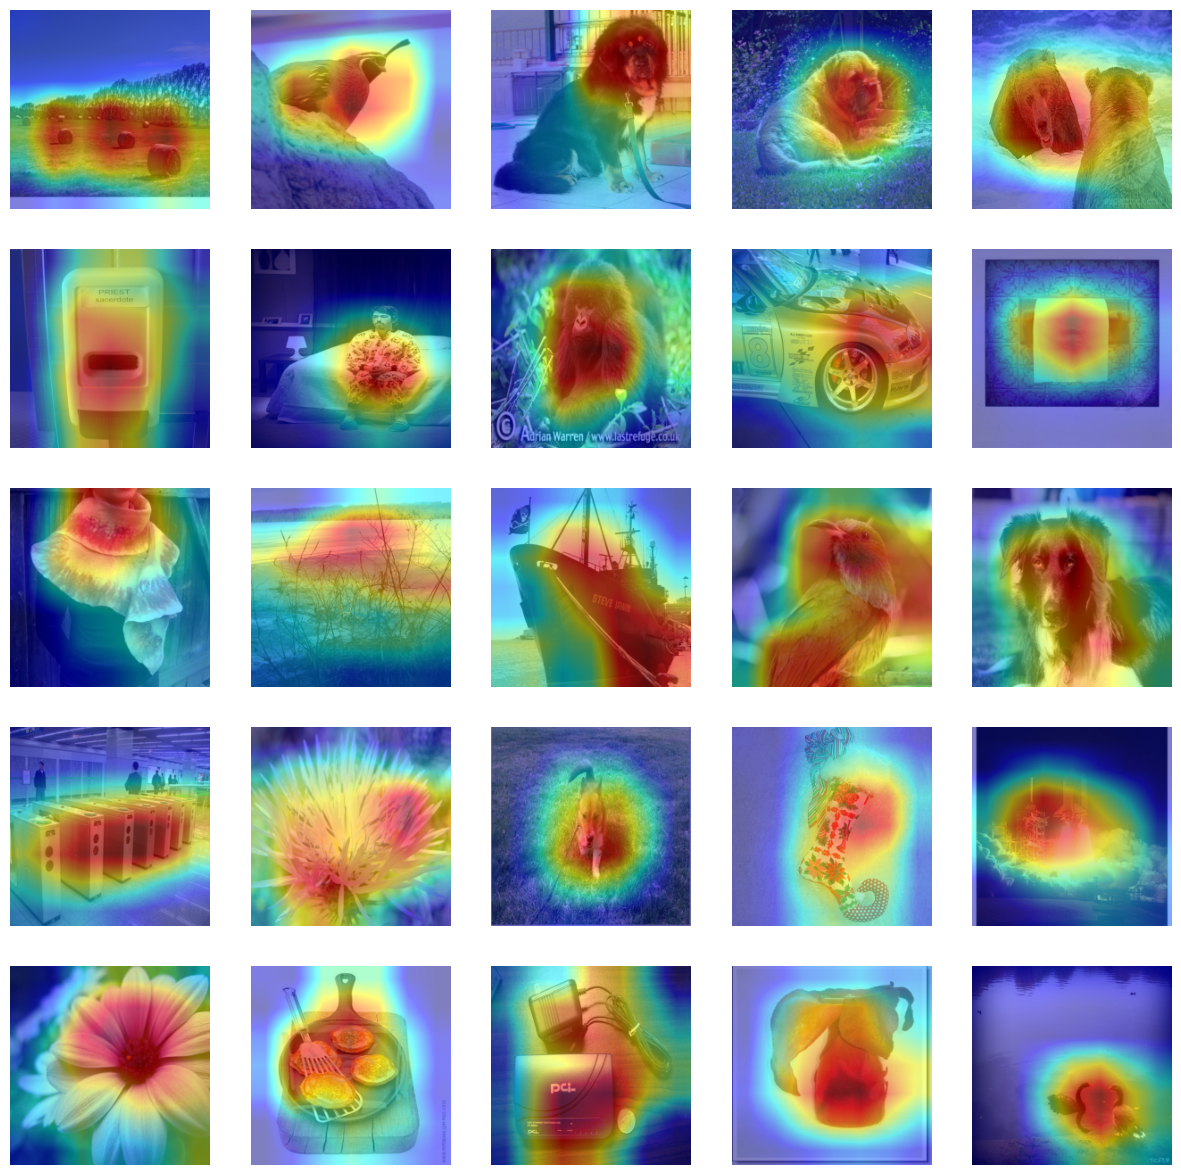

In [35]:
grayscale_cams = [cam.squeeze() for cam in grayscale_cam]  # Removing any extra dimensions

num_images_to_display = 25

columns = 5  # Number of columns in the grid
rows = math.ceil(num_images_to_display / columns)  # Calculate the number of rows needed

fig, axes = plt.subplots(rows, columns, figsize=(15, rows * 3))  # Adjust figsize as needed
axes = axes.flatten()  # Flatten the axes array for easy indexing

for i in range(num_images_to_display):
    if i < len(X):
        # Normalize image
        img = X[i] / 255.0
        img = np.float32(img)  # Ensure it's float32

        # Get the corresponding CAM
        cam_image = grayscale_cams[i]

        # Overlay CAM on the image
        visualization = show_cam_on_image(img, cam_image, use_rgb=True)

        ax = axes[i]
        ax.imshow(visualization)
        ax.axis('off')
    else:
        break  # Break if there are no more images

# Hide any unused axes if there are fewer images than subplots
for ax in axes[num_images_to_display:]:
    ax.axis('off')

plt.show()

**Implementation avec inception_v4**

In [36]:
import timm
model = timm.create_model('inception_v4', pretrained=True)
model.eval()

print("yo")

yo


In [37]:
def preprocess_inception_v4(img, size=299):
    transform = transforms.Compose([
        transforms.Resize(size),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
        transforms.Lambda(lambda x: x[None]),  # add one dimension
    ])
    return transform(img)

In [38]:
with torch.no_grad():
    out = model(torch.Tensor(X[0]).permute(2,0,1).unsqueeze(0))
probabilities = torch.nn.functional.softmax(out[0], dim=0)
print(probabilities.shape)

torch.Size([1000])


In [39]:
def ADP(model, x_clean, y_true, epsilon, T, alpha, m):
    x_adv = []
    x_adv.append(x_clean)

    for t in range(T):
        g = 0
        M = cam(input_tensor=x_adv[t], targets=targets)


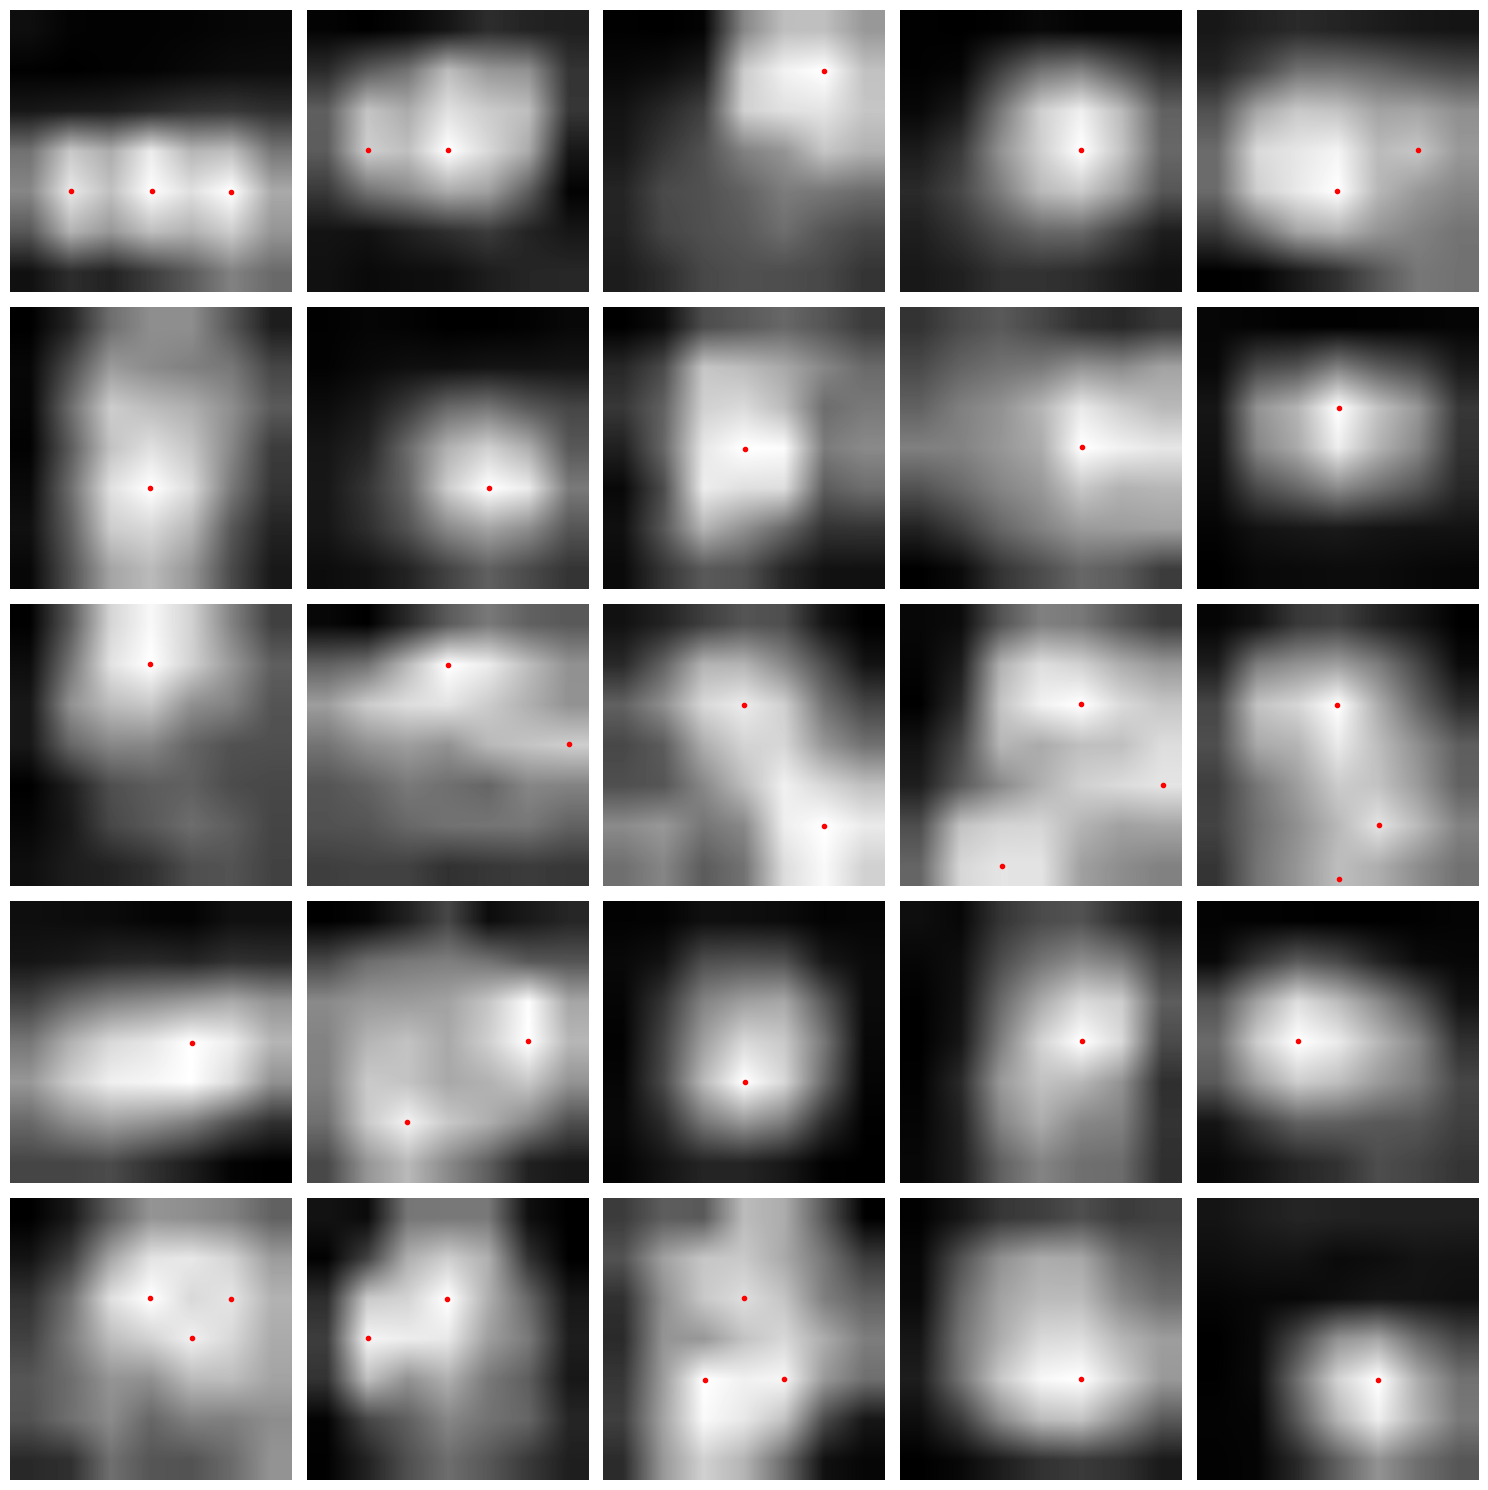

In [40]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.feature import peak_local_max

# Assuming grayscale_cams is defined
# Example adjustment: Let's create a dummy list of 25 random images for demonstration
# grayscale_cams = [np.random.rand(100, 100) for _ in range(25)]

fig, axes = plt.subplots(5, 5, figsize=(15, 15))
axes = axes.flatten()

for i, ax in enumerate(axes):
    M = grayscale_cams[i]
    ax.imshow(M, cmap='gray')
    
    # Find coordinates of local maxima
    coordinates = peak_local_max(M, num_peaks=3, exclude_border=False, min_distance=20)
    
    # Extract the values at these coordinates
    maxima_values = M[coordinates[:, 0], coordinates[:, 1]]
    
    # Determine the highest value among the maxima
    highest_maxima_value = max(maxima_values)
    
    # Filter coordinates based on the threshold
    filtered_coordinates = coordinates[maxima_values >= 0.6 * highest_maxima_value]
    
    # Plot the filtered coordinates on the images
    ax.plot(filtered_coordinates[:, 1], filtered_coordinates[:, 0], 'r.')
    ax.set_axis_off()

plt.tight_layout()
plt.show()
